In [3]:
### Declare libraries, parameters, and read in well data ###

import pandas as pd
from climateservaccess import datatypeDict

REGION = 'gambia'
# combined_datatype = 'LIS_Streamflow'
datatype_name = datatypeDict[26]
DATATYPE = datatype_name.lower()

original_data_path = f"../../data/original_data/climateserv/{DATATYPE}/{REGION}"
processed_data_path = f"../../data/processed_data/climateserv/{DATATYPE}/{REGION}"
climateserv_datatypes = [
    26
]

# Read in well data
original_df = pd.read_csv(f'../../data/processed_data/final_data_{REGION}.csv')
wells_df = pd.read_csv(f'../../data/processed_data/igrac/wells_{REGION}.csv')
wells_df.head()

,ID,Name,Status,Latitude,Longitude,Ground surface elevation
0,0000058001,Yoro Beri Kunda,Active,13.498482,-14.757303,17.40
1,0000035001,Pakaliba,Active,13.517245,-15.242125,13.34
2,0000024001,Somita,Active,13.208963,-16.298932,27.31
3,0000023001,Taneneh,Active,13.233057,-16.504728,14.32
4,0000020007,Mandinari OB3,Active,13.362761,-16.637219,30.47


RED = URBAN 
GREEN = RURAL


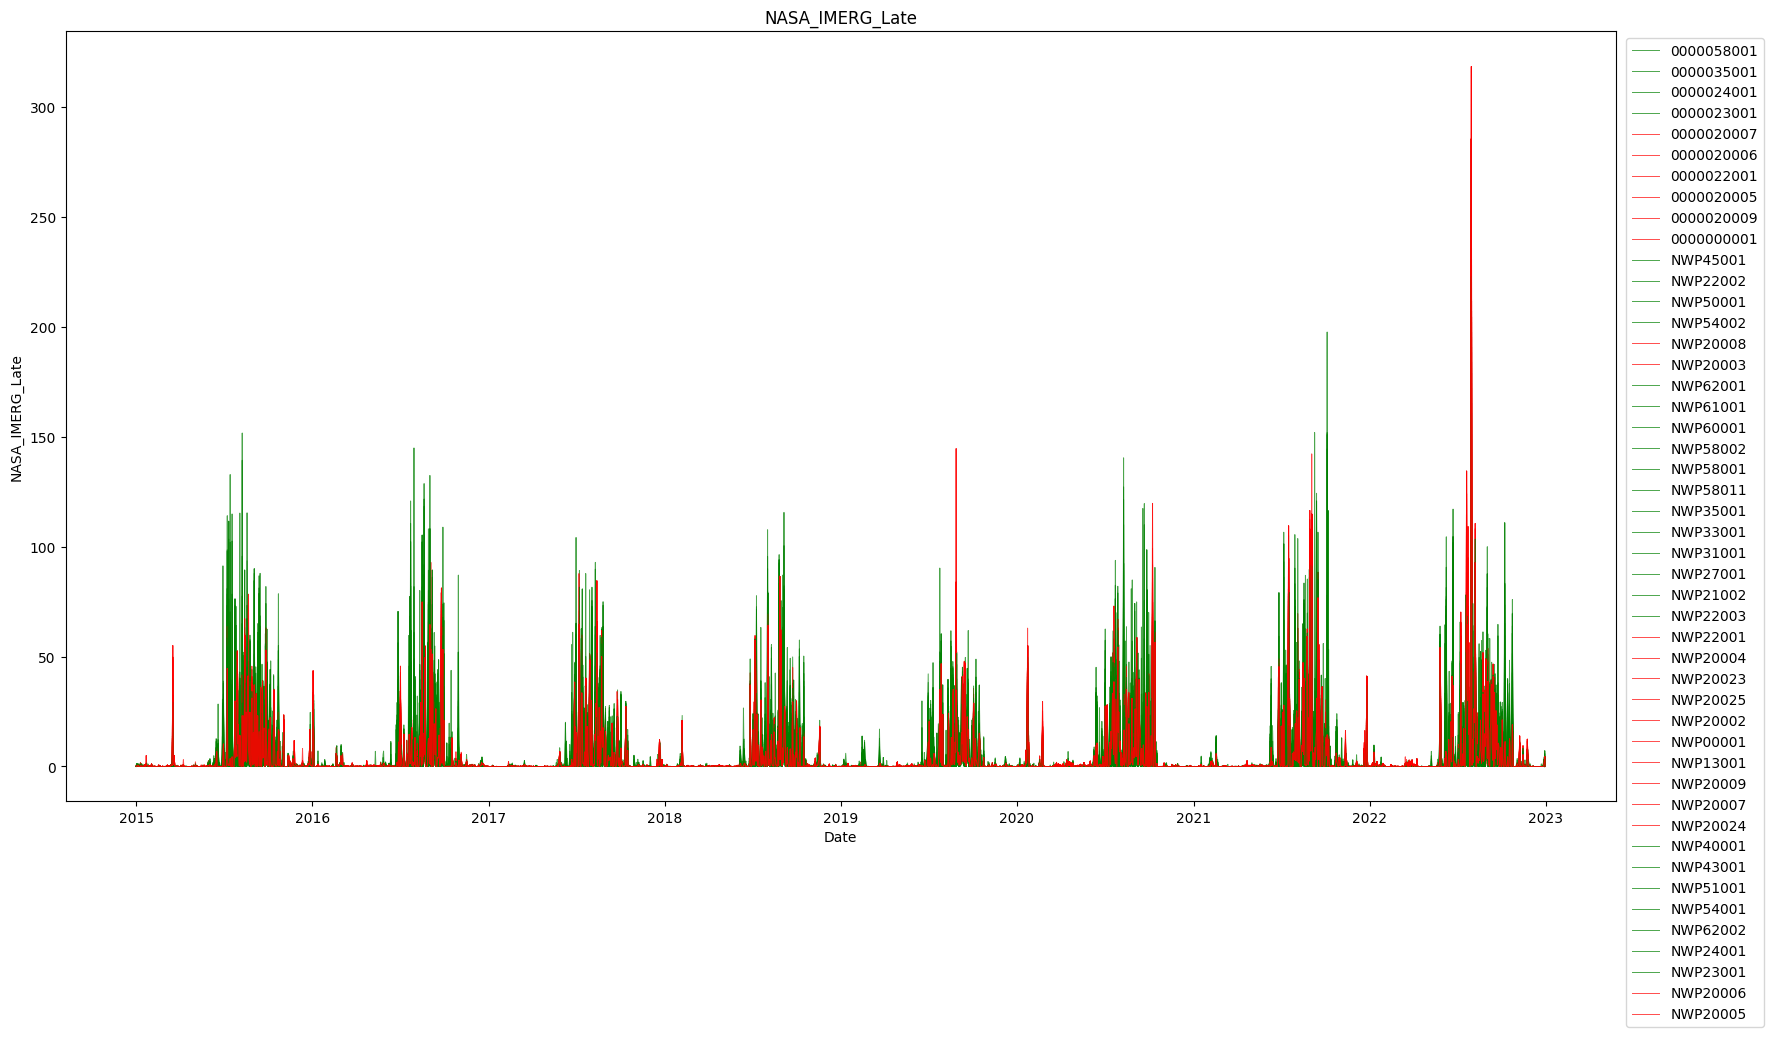

In [5]:
### Visualize each datatype for each well ###

import matplotlib.pyplot as plt
from climateservaccess import datatypeDict

plots = []
fig = plt.figure(figsize=(20, 10*len(climateserv_datatypes)))
for i in range(len(climateserv_datatypes)):
    datatype_num = climateserv_datatypes[i]
    datatype = datatypeDict[datatype_num]
    ax = fig.add_subplot(len(climateserv_datatypes), 1, i+1)
    ax.set_title(f'{datatype}')
    ax.set_xlabel('Date')
    ax.set_ylabel(datatype)
    plots.append(ax)

for index, row in wells_df.iterrows():
    well = row['ID']

    # Read in csv data
    df = pd.read_csv(f'{original_data_path}/{well}.csv')
    df['Date'] = pd.to_datetime(df['Date'])
        
    # Fill NaN values with linear interpolation
    df = df.interpolate(method='linear', limit_direction='both')
    
    # Pick plot color
    if row['Longitude'] < -16.6 and row['Latitude'] > 13.31: # Urban Areas (Banjul)
        color = 'red'
    else: # Rural Areas
        color = 'green'

    # Add data to plot
    for datatype_num in climateserv_datatypes:
        datatype = datatypeDict[datatype_num]
        plots[0].plot(df['Date'], df[datatype], label=well, linewidth=0.7, alpha=0.7, color=color)
        if datatype_num % 2 == 0: # Add legend for every other plot
            plots[0].legend(loc='upper right', prop={'size': 10}, bbox_to_anchor=(1.1, 1.0)) 

print('RED = URBAN \nGREEN = RURAL')

plt.show()

In [6]:
### Export combined data for each well ###

from climateservaccess import datatypeDict

for index, row in wells_df.iterrows():
    well = row['ID']

    # Read in csv data
    df = pd.read_csv(f'{original_data_path}/{well}.csv')
    df['Date'] = pd.to_datetime(df['Date'])
        
    # Fill NaN values with linear interpolation
    df = df.interpolate(method='linear', limit_direction='both')

    # Remove all other columns
    df = df[['Date', datatype_name]]
    
    # Export
    df.to_csv(f'{processed_data_path}/{well}.csv', index=False)

print(f"Data exported to {processed_data_path}")

Data exported to ../../data/processed_data/climateserv/nasa_imerg_late/gambia


In [7]:
original_df.head()

,ID,GROUNDWATER_LEVEL,Day,Month,Year,Latitude,Longitude,Ground surface elevation,LIS_Soil_Moisture_Combined,LIS_Streamflow,LIS_ET,Date,MOD13Q1_061__250m_16_days_EVI,MOD13Q1_061__250m_16_days_MIR_reflectance,MOD13Q1_061__250m_16_days_NDVI
0,NWP00001,14.26,14,4,2016,13.420804,-16.716666,19.47,0.172124,0.059371,0.219499,2016-04-14,0.2113,0.3972,0.2564
1,NWP00001,13.82,26,12,2015,13.420804,-16.716666,19.47,0.210837,0.136391,1.412334,2015-12-26,0.2443,0.1787,0.4064
2,NWP00001,13.82,25,12,2015,13.420804,-16.716666,19.47,0.211614,0.138738,1.612549,2015-12-25,0.2443,0.1787,0.4064
3,NWP00001,13.83,24,12,2015,13.420804,-16.716666,19.47,0.212448,0.141231,1.522625,2015-12-24,0.2443,0.1787,0.4064
4,NWP00001,13.83,23,12,2015,13.420804,-16.716666,19.47,0.213260,0.143826,1.481390,2015-12-23,0.2443,0.1787,0.4064


In [8]:
### Merge data into original merged DataFrame ###

def read_original_data(well):
    df = pd.read_csv(f'{processed_data_path}/{well}.csv', parse_dates=['Date'])
    df = df.set_index('Date')
    df = df.rename(columns={datatype_name: well})
    return df

# Read all soil moisture CSV files and concatenate them into one DataFrame with columns named for each
dfs = [read_original_data(well) for well in original_df['ID'].unique()]
soil_moisture_df = pd.concat(dfs, axis=1)

# Merge data
merged_df = original_df.copy()
merged_df[datatype_name] = 0

for index, row in original_df.iterrows():

    well = row['ID']
    
    # Merge
    merged_df[datatype_name][index] = soil_moisture_df[well][row['Date']]

C:\Users\Adam Zheng\AppData\Local\Temp\ipykernel_32480\717825550.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[datatype_name][index] = soil_moisture_df[well][row['Date']]
C:\Users\Adam Zheng\AppData\Local\Temp\ipykernel_32480\717825550.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[datatype_name][index] = soil_moisture_df[well][row['Date']]


In [9]:
merged_df.head()

,ID,GROUNDWATER_LEVEL,Day,Month,Year,Latitude,Longitude,Ground surface elevation,LIS_Soil_Moisture_Combined,LIS_Streamflow,LIS_ET,Date,MOD13Q1_061__250m_16_days_EVI,MOD13Q1_061__250m_16_days_MIR_reflectance,MOD13Q1_061__250m_16_days_NDVI,NASA_IMERG_Late
0,NWP00001,14.26,14,4,2016,13.420804,-16.716666,19.47,0.172124,0.059371,0.219499,2016-04-14,0.2113,0.3972,0.2564,0.0
1,NWP00001,13.82,26,12,2015,13.420804,-16.716666,19.47,0.210837,0.136391,1.412334,2015-12-26,0.2443,0.1787,0.4064,1.3
2,NWP00001,13.82,25,12,2015,13.420804,-16.716666,19.47,0.211614,0.138738,1.612549,2015-12-25,0.2443,0.1787,0.4064,0.0
3,NWP00001,13.83,24,12,2015,13.420804,-16.716666,19.47,0.212448,0.141231,1.522625,2015-12-24,0.2443,0.1787,0.4064,0.1
4,NWP00001,13.83,23,12,2015,13.420804,-16.716666,19.47,0.213260,0.143826,1.481390,2015-12-23,0.2443,0.1787,0.4064,0.0


In [10]:
# Export merged data

merged_df.to_csv(f'../../data/processed_data/final_data_{REGION}.csv', index=False)